# かがわAIゼミナール2019
## 課題１ : kickstarter-projects
## クラウドファンデイングが成功するか(state)を予測

#### DATA:kaggle   https://www.kaggle.com/kemical/kickstarter-projects
#### 注意点）　説明変数は現時点でわかっている情報だけを使用すること

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from datetime import datetime, date

In [2]:
# データ読み込み
df_data_csv = pd.read_csv("./kickstarter-projects/ks-projects-201801.csv") 
display(df_data_csv.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


項目
- ID
- name
- category
- main_category
- currency : 通貨
- deadline : 締め切り日
- goal : Goal amount in project currency : プロジェクト通過での目標額
- launched : 開始日時
- pledged : Pledged amount in the project currency : プロジェクト通貨での元本額
- state : 状態
- backers : 支援者数
- country : 国
- usd pledged : Pledged amount in USD (conversion made by KS) : 担保金額（米ドル）（KSによる変換）
- usd_pledged_real : Pledged amount in USD (conversion made by fixer.io api) : 担保金額（米ドル）
- usd_goal_real : Goal amount in USD : 目標額（米ドル）

（プロジェクトスタート時に取得できない情報、backers と pledged　→　使用しない）

In [3]:
# 行列数確認
print(df_data_csv.shape)

(378661, 15)


In [4]:
# 基本情報
df_data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
# 統計量表示
df_data_csv.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [6]:
# 欠損値がないか確認
print(df_data_csv.isnull().sum())

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


In [7]:
# 説明変数に使用予定のnameのnan値の行を除いておく
df_data_csv = df_data_csv.dropna(subset=['name'])

まずは、今回の目標である「成功するかしないか」の二値分類にするため、目的変数stateの中身を確認する

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64


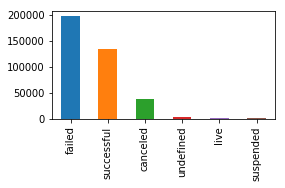

In [8]:
print(df_data_csv['state'].value_counts())
df_data_csv['state'].value_counts().plot.bar(figsize=(4, 2))

- failed : 失敗
- successful : 成功
- canceled : 中止
- undefined : 未定義
- live : 進行中
- suspended : 中断
### → 成功successfulと失敗failedだけを使用し、それ以外を取り除く

In [9]:
df_data = df_data_csv[(df_data_csv['state'] == "failed") | (df_data_csv['state'] == "successful")]
df_data.shape

(331672, 15)

（成功'successful' : 1, その他（'failed'）：0） に置き換える

In [10]:
# クラウドファウンディングが成功：１、失敗：０に変換
df_data['state'] = np.where(df_data['state'] == "successful", 1, 0)

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


使えそうな説明変数をピックアップ
- name
- category
- main_category
- state
- country
- usd_goal_real
- day_diff : 資金を集められる期間( = deadline - launched)（オリジナル）
- launch_year : 開始年(launched)（オリジナル）

In [11]:
# 資金を集められる期間（開始日と締め切り日の差(day_diff)）が関係ありそうなので表に追加
# 文字列データをdatetimeに変換
df_data['deadline'] = df_data['deadline'].apply(lambda x:datetime.strptime(x[:10], "%Y-%m-%d"))
df_data['launched'] = df_data['launched'].apply(lambda x:datetime.strptime(x[:10], "%Y-%m-%d"))
# 日数の差
day_diff = (df_data['deadline'] - df_data['launched']).apply(lambda x: x.days)
# 追加
df_data['day_diff'] = day_diff
# 募集を行った年を追加してみる
df_data['launch_year']=pd.to_datetime(df_data['launched'], format="%Y/%m/%d").dt.year

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is 

In [12]:
# 使用するカラムを選択
# df_data = df_data[['name','category','main_category', 'state', 'country', 'usd_goal_real', 'day_diff','launch_year']]
# launch_yearを使わない方が精度が高い
df_data = df_data[['name','category','main_category', 'state', 'country', 'usd_goal_real', 'day_diff']]

df_data.head()

,name,category,main_category,state,country,usd_goal_real,day_diff
0,The Songs of Adelaide & Abullah,Poetry,Publishing,0,GB,1533.95,59
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,0,US,30000.00,60
2,Where is Hank?,Narrative Film,Film & Video,0,US,45000.00,45
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,0,US,5000.00,30
5,Monarch Espresso Bar,Restaurants,Food,1,US,50000.00,35


### データの整理（前処理）

- 欠損値Nanチェック
- 外れ値チェック
- カテゴリ変数をダミー変数に変換　category, main_category, country
- カテゴリはメインカテゴリを使うか詳細なカテゴリを使うか
- データ数が37万件と多いため、ランダムにサンプリングする

In [13]:
# 欠損値がないか確認
print(df_data.isnull().sum())

name             0
category         0
main_category    0
state            0
country          0
usd_goal_real    0
day_diff         0
dtype: int64


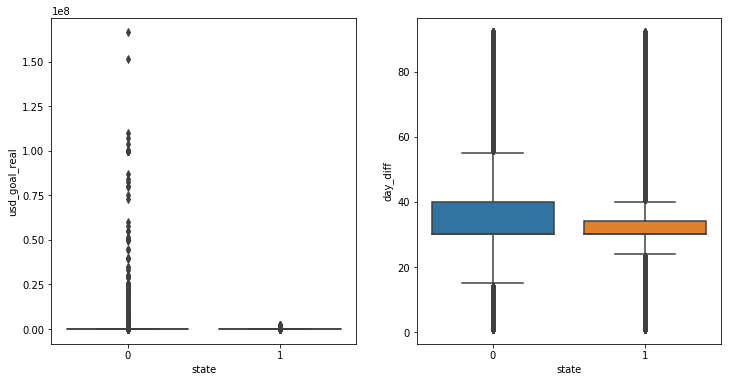

In [14]:
# 外れ値がないか確認
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(x='state', y='usd_goal_real',  data=df_data, ax=ax[0])
sns.boxplot(x='state', y='day_diff',  data=df_data, ax=ax[1])

箱ひげ図より外れ値が大きいことがわかるので、usd_goal_realとday_diffの外れ値を除く

In [15]:
# 外れ値を除く
df_data = df_data[df_data['usd_goal_real'] < 40000]
# df_data = df_data[df_data['day_diff'] < 1000]

In [16]:
# 統計量表示
df_data.describe()

,state,usd_goal_real,day_diff
count,297201.000000,297201.000000,297201.000000
mean,0.431711,7712.209993,33.513730
std,0.495316,8355.439676,12.658393
min,0.000000,0.010000,1.000000
25%,0.000000,1644.140000,30.000000
50%,0.000000,5000.000000,30.000000
75%,1.000000,10000.000000,35.000000
max,1.000000,39999.000000,92.000000


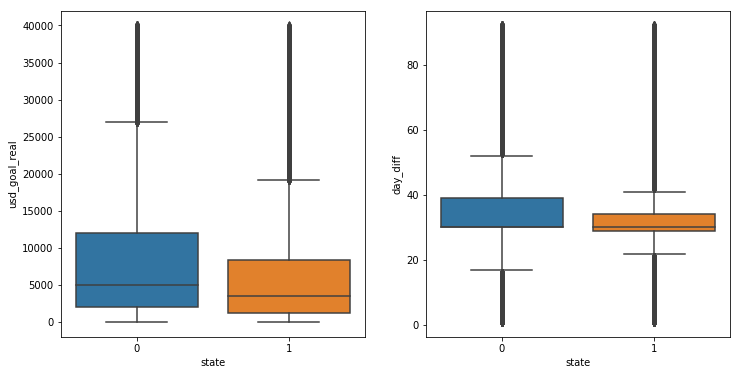

In [17]:
# 箱ひげ図をもう一度表示
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(x='state', y='usd_goal_real',  data=df_data, ax=ax[0])
sns.boxplot(x='state', y='day_diff',  data=df_data, ax=ax[1])

In [18]:
# カテゴリーについて、メインカテゴリを使うか詳細なカテゴリを使うか
print(df_data['category'].value_counts())
# 159種
print(df_data['main_category'].value_counts())
# 15種
#  →　種類の少ないmain_categoryを使用してみる

Product Design       15439
Documentary          12063
Music                12000
Shorts               11190
Tabletop Games       11045
Food                  9195
Fiction               7900
Video Games           7198
Film & Video          7189
Art                   7104
Fashion               7057
Nonfiction            7025
Theater               6379
Rock                  6126
Children's Books      6062
Apparel               5739
Indie Rock            5277
Photography           5097
Webseries             4714
Publishing            4670
Comics                4447
Country & Folk        4164
Crafts                4005
Apps                  3859
Technology            3804
Narrative Film        3677
Web                   3418
Hip-Hop               3280
Design                3112
Pop                   2950
                     ...  
Space Exploration      204
Couture                201
Civic Design           198
Printing               191
Stationery             188
Puzzles                188
V

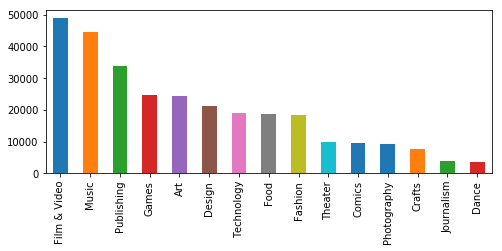

In [19]:
df_data['main_category'].value_counts().plot.bar(figsize=(8, 3))

state=1の時のmain_category毎のカウント


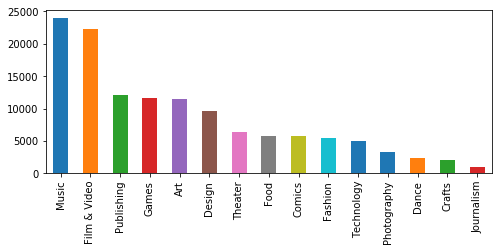

In [20]:
df_data_1 = df_data[df_data['state']==1] 
print("state=1の時のmain_category毎のカウント")
df_data_1['main_category'].value_counts().plot.bar(figsize=(8, 3))

In [21]:
# カテゴリ変数をダミー変数に変換（One-Hotベクトル）

# category
df_data = pd.concat([df_data, pd.get_dummies(df_data['main_category'])], axis=1)
df_data = df_data.drop(['category','main_category'], axis=1)
df_data.head()

,name,state,country,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,The Songs of Adelaide & Abullah,0,GB,1533.95,59,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,0,US,30000.00,60,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,ToshiCapital Rekordz Needs Help to Complete Album,0,US,5000.00,30,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,Support Solar Roasted Coffee & Green Energy! ...,1,US,1000.00,20,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,Chaser Strips. Our Strips make Shots their B*tch!,0,US,25000.00,45,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


次にcountryについて検討する

country毎のカウント


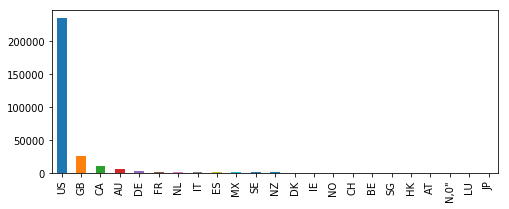

In [22]:
print("country毎のカウント")
df_data['country'].value_counts().plot.bar(figsize=(8, 3))

state=1の時のcountry毎のカウント


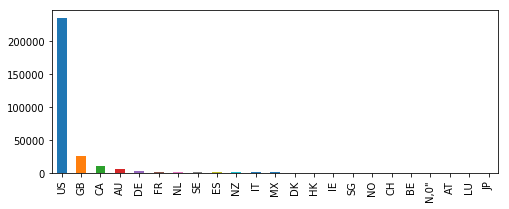

In [23]:
print("state=1の時のcountry毎のカウント")
df_data['country'].value_counts().plot.bar(figsize=(8, 3))
df_data_1['country'].value_counts().plot.bar(figsize=(8, 3))

→　USがデータの大部分を占めていることがわかる

In [24]:
# country
# df_data = pd.concat([df_data, pd.get_dummies(df_data['country'])['US']], axis=1)
df_data = pd.concat([df_data, pd.get_dummies(df_data['country'])], axis=1)

df_data = df_data.drop(['country'], axis=1)
df_data.head()

,name,state,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
0,The Songs of Adelaide & Abullah,0,1533.95,59,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,0,30000.00,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,ToshiCapital Rekordz Needs Help to Complete Album,0,5000.00,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,Support Solar Roasted Coffee & Green Energy! ...,1,1000.00,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,Chaser Strips. Our Strips make Shots their B*tch!,0,25000.00,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


nameについて検討する

In [25]:
df_data['name'].value_counts()

New EP/Music Development                                                          15
Music Video                                                                       11
New EP / Music Development                                                        10
Debut Album                                                                        9
Pizza                                                                              8
Reflections                                                                        8
Pasta Salad                                                                        7
A Midsummer Night's Dream                                                          7
Chocolate Chip Cookies                                                             6
Through My Eyes                                                                    6
The Awakening                                                                      6
Guacamole                                                        

In [26]:
print("state=1の時のname毎のカウント")
df_data_1['name'].value_counts()

state=1の時のname毎のカウント


Reflections                                                    5
Artist Residency at the Vermont Studio Center                  5
Debut Album                                                    5
A Midsummer Night's Dream                                      5
Nocturne                                                       4
MFA Thesis Exhibition                                          4
Gruesome Playground Injuries                                   4
Terminus                                                       3
Love Letters                                                   3
Thicker Than Water                                             3
The End                                                        3
Collision                                                      3
Slow Burn                                                      3
Chocolate Chip Cookies                                         3
Make-Believe                                                   3
Ashes                    

In [27]:
# 分割してみる
df_name = df_data[['name','state']]

df_name['name'] = df_name['name'].str.split()
df_name

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,name,state
0,"[The, Songs, of, Adelaide, &, Abullah]",0
1,"[Greeting, From, Earth:, ZGAC, Arts, Capsule, ...",0
3,"[ToshiCapital, Rekordz, Needs, Help, to, Compl...",0
6,"[Support, Solar, Roasted, Coffee, &, Green, En...",1
7,"[Chaser, Strips., Our, Strips, make, Shots, th...",0
10,"[Of, Jesus, and, Madmen]",0
11,"[Lisa, Lim, New, CD!]",1
12,"[The, Cottage, Market]",0
14,"[Tombstone:, Old, West, tabletop, game, and, m...",1
15,"[Survival, Rings]",0


In [28]:
# chg_x = lambda x : x / x.sum()

# # name_group = df_data.groupby('name')['state'].transform(chg_x)
# df_name_group = df_data[['name','state']].dropna(axis = 0, how = 'any')
# df_name_group
# # name_group = df_name_group.groupby('name')['state'].transform(chg_x)
# # name_group
# # df_name_group.sort_values(by=["state", "name"], ascending=True)

In [29]:
# df.groupby('name')['weight'].filter(lambda x: x.min() > x.max()/1.3)

In [30]:
# nameを上手く変換し活用できなかったため除く
df_data = df_data.drop(['name'], axis=1)

In [31]:
# サンプルデータをランダムに2万件取得　
df_data_a = df_data.sample(n=20000, random_state=123)
df_data_a.head()

,state,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
46982,0,10000.0,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
107299,0,4500.0,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
371960,1,9165.3,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28126,0,614.0,20,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187583,0,900.0,30,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
df_data_a.describe()

,state,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.422350,7731.243744,33.498800,0.082350,0.031100,0.024600,0.011150,0.073500,0.059050,0.162900,...,0.000150,0.000200,0.004350,0.000650,0.00705,0.002250,0.003550,0.004000,0.000950,0.787350
std,0.493946,8388.977830,12.584555,0.274904,0.173592,0.154907,0.105006,0.260962,0.235724,0.369284,...,0.012247,0.014141,0.065813,0.025487,0.08367,0.047382,0.059478,0.063121,0.030808,0.409192
min,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1635.412500,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,5000.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,10000.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,39999.000000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 目的変数と各説明変数の関係を調査する

In [33]:
# 相関係数を確認
# df_data_a.corr()

In [34]:
# 相関係数をヒートマップにして可視化
# sns.heatmap(df_data_a.corr())
# plt.show()

### ホールドアウト法
- データを事前に学習用とテスト用に分割し、テスト用データで学習済みモデルの汎化誤差を評価する方法のこと

In [35]:
y = df_data_a.loc[:,['state']].values
X = df_data_a.drop('state', axis=1).values
#学習用データとテスト用データを分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [36]:
#データの標準化
scl = StandardScaler()
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

In [37]:
scl.mean_, scl.scale_

(array([7.74937399e+03, 3.35374375e+01, 8.21875000e-02, 3.18125000e-02,
        2.53125000e-02, 1.11875000e-02, 7.33125000e-02, 5.73750000e-02,
        1.65687500e-01, 6.33750000e-02, 7.90625000e-02, 1.28750000e-02,
        1.50500000e-01, 3.24375000e-02, 1.15687500e-01, 6.41875000e-02,
        3.50000000e-02, 1.25000000e-03, 2.12500000e-02, 9.37500000e-04,
        3.80000000e-02, 2.25000000e-03, 9.00000000e-03, 2.00000000e-03,
        5.81250000e-03, 7.43750000e-03, 8.98750000e-02, 1.50000000e-03,
        1.62500000e-03, 7.12500000e-03, 1.87500000e-04, 1.87500000e-04,
        4.25000000e-03, 5.62500000e-04, 6.93750000e-03, 2.31250000e-03,
        3.62500000e-03, 3.62500000e-03, 1.06250000e-03, 7.89187500e-01]),
 array([8.39299705e+03, 1.25782788e+01, 2.74650168e-01, 1.75500612e-01,
        1.57072523e-01, 1.05177658e-01, 2.60648762e-01, 2.32557755e-01,
        3.71799882e-01, 2.43636223e-01, 2.69836286e-01, 1.12735240e-01,
        3.57560834e-01, 1.77158992e-01, 3.19849812e-01, 2.4508

2値のエントロピー

In [38]:
def entropy(px):
    """
    px : array like
    """
    px = np.array(px).astype(float)
    px[px==0] = 1e-10 #logx(0)は計算できないため、小さな値に置き換えておく
    return -1 * np.sum(px*np.log2(px))

def gini_index(px):
    """
    px : array like
    """
    px = np.array(px).astype(float)
    return 1 - np.sum(px ** 2)

def entropy_and_gini_index_plot(px):
    pd.DataFrame(px).plot.bar(figsize=(7,2))
    plt.ylim([0,1.0])
    plt.ylabel("p(x)")
    plt.xlabel("Discrete probablity variable")
    title = "Entropy = %s  "% round(entropy(px),4) + "Gini index = %s"% round(gini_index(px),4)
    plt.title(title)
    plt.show()

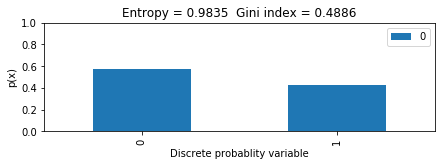

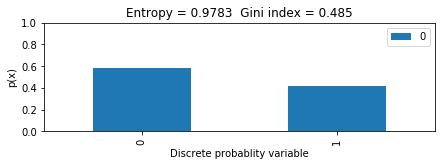

In [39]:
p1 = len(y_train[y_train == 0]) / len(y_train)
p2 = 1 - p1
p3 = len(y_test[y_test == 0]) / len(y_test)
p4 = 1- p3

entropy_and_gini_index_plot([p1, p2])
entropy_and_gini_index_plot([p3, p4])

## ロジスティック回帰を使って学習

In [40]:
# ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=123)
clf.fit(X_train_std, y_train)

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=123,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [41]:
# ラベルを予測
y_pred = clf.predict(X_test_std)

In [42]:
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred)))
# 正答率を表示
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred)))
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -13.038
正答率（Accuracy） = 62.250%
適合率（Precision） = 65.145%
再現率（Recall） = 76.641%
F1値（F1-score） = 70.427%


In [43]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0,1]), 
                        index=['正解 = 成功', '正解 = 失敗'], 
                        columns=['予測 = 成功', '予測 = 失敗'])
conf_mat

,予測 = 成功,予測 = 失敗
正解 = 成功,1798,548
正解 = 失敗,962,692


In [44]:
print("学習データ識別精度=",clf.score(X_train_std, y_train))
print("テストデータ識別精度=",clf.score(X_test_std, y_test))

学習データ識別精度= 0.6266875
テストデータ識別精度= 0.6225


In [45]:
# モデルの傾き
clf.coef_

array([[-2.50821031e-01, -1.97628990e-01,  6.36726421e-03,
         9.34342063e-02, -1.38658023e-01,  9.78833773e-02,
         5.75149336e-02, -1.43925511e-01,  5.08716233e-02,
        -6.93404018e-02,  5.32898089e-02, -7.68919110e-02,
         1.63065117e-01, -5.21458981e-02, -1.12020182e-01,
        -1.51828215e-01,  1.52678837e-01,  2.78850570e-02,
         2.50464212e-02,  1.66575672e-02,  6.70147344e-02,
         4.20053837e-02,  1.64793186e-02,  2.81093086e-02,
        -4.54144739e-02,  4.88295898e-02,  1.41447102e-01,
         3.98230595e-02,  5.52131473e-03, -2.30117423e-02,
        -1.61989357e-03, -1.31249054e+01, -3.44295142e-03,
         1.26160626e-02,  2.03680264e-02,  4.49261761e-02,
         3.18478258e-02,  4.06537891e-02,  2.39186781e-02,
         2.62125901e-01]])

In [46]:
# モデルの切片
clf.intercept_

array([-0.51254664])

重みが0.1以下を省いてみる

In [47]:
display(df_data_a.head())
# 除く
# Art, Comics, Dancd, Fashion, Food, Journalism, publishing
# df_data_a = df_data_a.drop(['Art',  'Fashion', 'Food', 'Journalism', 'Publishing'], axis=1)

,state,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
46982,0,10000.0,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
107299,0,4500.0,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
371960,1,9165.3,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28126,0,614.0,20,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187583,0,900.0,30,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
# X = df_data_a.drop('state', axis=1).values
# #学習用データとテスト用データを分ける
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

# #データの標準化
# X_train_std2 = scl.fit_transform(X_train)
# X_test_std2 = scl.transform(X_test)

In [49]:
# # ロジスティック回帰
# clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=123)
# clf.fit(X_train_std2, y_train)
# # ラベルを予測
# y_pred = clf.predict(X_test_std2)
# # 対数尤度を表示
# print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred)))
# # 正答率を表示
# print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred)))
# # Precision, Recall, F1-scoreを計算
# precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
# # Precision, Recall, F1-scoreを表示
# print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
# print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
# print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))


In [50]:
# # 予測値と正解のクロス集計
# conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0,1]), 
#                         index=['正解 = 成功', '正解 = 失敗'], 
#                         columns=['予測 = 成功', '予測 = 失敗'])
# conf_mat

In [51]:
# print("学習データ識別精度=",clf.score(X_train_std2, y_train))
# print("テストデータ識別精度=",clf.score(X_test_std2, y_test))

## サポートベクターマシーン

In [52]:
# クラウドファウンディングが成功：１、失敗：-1に変換
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

#### グリッドサーチ

In [53]:
%%time
parameters = {'kernel':['linear', 'rbf'], 'C':[0.1], 'gamma':[1]} # グリッドサーチの結果、左記が最適だった
#parameters = {'kernel':['linear', 'rbf'], 'C':[0.5], 'gamma':[1]} 
#parameters = {'kernel':['rbf'], 'C':[0.1, 0.5, 1], 'gamma':[1]} 

model = SVC()
clf3 = GridSearchCV(model, parameters, cv=3,)
clf3.fit(X_train_std, y_train)
print(clf3.best_params_, clf3.best_score_)

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:578: D

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'} 0.62375
CPU times: user 1min 38s, sys: 1.1 s, total: 1min 39s
Wall time: 1min 38s


In [54]:
# 最適パラメータを用いて識別する
clf4 = SVC(**clf3.best_params_)
clf4.fit(X_train_std, y_train)
print("学習データ識別精度=",clf4.score(X_train_std, y_train))
print("テストデータ識別精度=",clf4.score(X_test_std, y_test))

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


学習データ識別精度= 0.6294375
テストデータ識別精度= 0.61725


In [55]:
# SVMの実行
C = 0.1
kernel = "rbf"
gamma = 1
clf2 = SVC(C=C, kernel=kernel, gamma=gamma)
clf2.fit(X_train_std, y_train)

# 未知のデータを識別する
print(clf2.predict(X_test_std))

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-1 -1 -1 ...  1 -1 -1]


In [56]:
# ラベルを予測
y_pred = clf2.predict(X_test_std)
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred)))
# 正答率を表示
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred)))
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -13.220
正答率（Accuracy） = 61.725%
適合率（Precision） = 62.990%
再現率（Recall） = 84.228%
F1値（F1-score） = 72.077%


In [57]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[-1,1]), 
                        index=['正解 = 成功', '正解 = 失敗'], 
                        columns=['予測 = 成功', '予測 = 失敗'])
conf_mat

,予測 = 成功,予測 = 失敗
正解 = 成功,1976,370
正解 = 失敗,1161,493


In [58]:
print("学習データ識別精度=",clf2.score(X_train_std, y_train))
print("テストデータ識別精度=",clf2.score(X_test_std, y_test))

学習データ識別精度= 0.6294375
テストデータ識別精度= 0.61725


→　ロジスティック回帰の方がSVMより少し精度が高くなった。しかし、特徴量を色々変えてみるとSVMの方が精度が高い場合もある。

L1正則化を用いて説明変数を減らす

In [59]:
LogisticRegression(penalty='l1')
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.6258125
Test accuracy: 0.62075


/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
# 係数
lr.coef_

array([[-0.24724378, -0.19486612,  0.        ,  0.08506757, -0.14005918,
         0.09165619,  0.04645107, -0.14898256,  0.0362903 , -0.07451079,
         0.04124114, -0.07729044,  0.14937641, -0.0549983 , -0.11955381,
        -0.15706197,  0.14426062,  0.00796936, -0.04424814,  0.        ,
        -0.02478436,  0.01525285, -0.02678135,  0.00260905, -0.07839844,
         0.00348952,  0.        ,  0.01838053, -0.0113485 , -0.0607284 ,
        -0.00630961, -0.03217576, -0.03188627,  0.        , -0.01757466,
         0.01766875,  0.        ,  0.00783361,  0.00530656,  0.0574866 ]])

In [61]:
# 切片
lr.intercept_

array([-0.32898917])

係数が0になった説明変数を除いて検証してみる

In [62]:
df_data_a.columns

Index(['state', 'usd_goal_real', 'day_diff', 'Art', 'Comics', 'Crafts',
       'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games',
       'Journalism', 'Music', 'Photography', 'Publishing', 'Technology',
       'Theater', 'AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB',
       'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'N,0"', 'NL', 'NO', 'NZ', 'SE',
       'SG', 'US'],
      dtype='object')

In [63]:
# 0.01以下を除く
# Art, AT, BE, DK, FR, GB, JP, N,0" , NZ, SE, SG
df_data_a = df_data_a.drop(['Art', 'AT', 'BE', 'DK', 'FR', 'GB', 'JP', 'N,0"', 'NZ','SE', 'SG'], axis=1)

In [64]:
X = df_data_a.drop('state', axis=1).values
#学習用データとテスト用データを分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)
#データの標準化
X_train_std3 = scl.fit_transform(X_train)
X_test_std3 = scl.transform(X_test)

In [65]:
# ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=123)
clf.fit(X_train_std3, y_train)
# ラベルを予測
y_pred = clf.predict(X_test_std3)

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred)))
# 正答率を表示
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred)))
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -12.969
正答率（Accuracy） = 62.450%
適合率（Precision） = 65.301%
再現率（Recall） = 76.769%
F1値（F1-score） = 70.572%


In [67]:
print("学習データ識別精度=",clf.score(X_train_std3, y_train))
print("テストデータ識別精度=",clf.score(X_test_std3, y_test))

学習データ識別精度= 0.627
テストデータ識別精度= 0.6245


#### →　L1によって求めた重みが0.01以下の説明変数を排除し、ロジスティック回帰で比較すると精度が上がった